In [1]:
import os
import argparse
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

import scipy.optimize
import numpy as np
from tqdm import tqdm
import matplotlib
from torch.optim import lr_scheduler

matplotlib.use("Agg")
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import data as data
import slot_attention_obj_discovery as model
import utils as utils
from rtpt import RTPT

torch.set_num_threads(30)

In [2]:
class WrappedModel(nn.Module):
    def __init__(self, module):
        super(WrappedModel, self).__init__()
        self.module = module
    def forward(self, x):
        return self.module(x)


def get_args():
    parser = argparse.ArgumentParser()
    args = parser.parse_args("")

    # generic params
#     args.resume = "/Users/ml-wstammer/Documents/PhD/repositories/XIConcept/CLEVR/slot_attention_obj_discovery_stacked/logs/slot-attention-clevr-objdiscovery-14"
    args.resume = "./logs/slot-attention-clevr-objdiscovery-14"
    args.data_dir = "/Users/ml-wstammer/Documents/PhD/datasets/CLEVR_v1"
    args.epochs = 500
    args.no_cuda = True
    args.num_workers = 4
    args.warm_up_steps = 10000
    args.lr = 0.0004
    args.batch_size = 4
    args.n_slots = 11
    args.n_attr_slots = 5
    args.n_iters_slot_att = 3
    args.n_attr = 18

    # if args.device_list_parallel is not None:
    #     args.device_list_parallel = [int(elem) for elem in args.device_list_parallel[0].split(',')]

    return args

In [3]:
%tb
args = get_args()

dataset_test = data.CLEVR(
    args.data_dir, "val",
)

test_loader = data.get_loader(
    dataset_test,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    shuffle=False,
)

net = model.SlotAttention_model(n_slots=args.n_slots, n_iters=args.n_iters_slot_att, n_attr=args.n_attr,
                                encoder_hidden_channels=64, attention_hidden_channels=128,
                                decoder_hidden_channels=64, decoder_initial_size=(8, 8))

net = WrappedModel(net)

start_epoch = 0
if args.resume:
    print("Loading ckpt ...")
    log = torch.load(args.resume, map_location=torch.device('cpu'))
    weights = log["weights"]
    net.load_state_dict(weights, strict=True)
    # start_epoch = log["args"]["epochs"]

if not args.no_cuda:
    net = net.to("cuda:0")

sample = next(iter(test_loader))

imgs, masks = sample
recon_combined, recons, masks, slots = net.forward(imgs)

Loading ckpt ...


No traceback available to show.


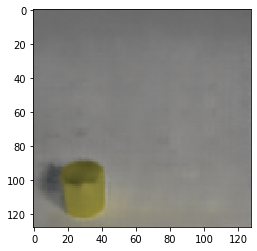

In [17]:
plt.figure()
plt.imshow(np.moveaxis(recons[0, 1].detach().cpu().numpy(), [0, 1, 2], [2, 0, 1]) / 2. + 0.5)
plt.show()

In [42]:
manip_slots = torch.clone(slots)
# manip_slots[0, 1, :10] = 0.
manip_slots[0, 1, 50:] = 0.
manip_slots[0, 1]

tensor([-0.2135,  0.6678,  1.1490, -0.6931, -0.3756, -0.2796, -0.4202,  0.1663,
        -0.0906, -0.3957, -0.2038,  0.2305,  0.4124,  0.1971,  0.2484, -0.2836,
         0.4374, -0.3586, -0.4252, -0.1798, -0.0066, -0.7084, -0.2813, -0.5695,
         0.4292,  0.3519,  0.5427,  0.5122,  0.9647, -0.7170, -0.5558,  0.5095,
         0.3917,  0.3264,  0.3553,  0.7456, -0.3363,  0.1790, -1.3475, -0.1944,
         0.2477,  0.8668,  0.0020, -0.2386, -0.3784,  1.0902,  0.1826,  0.4180,
         1.4955,  0.1480,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       grad_fn=<SelectBackward>)

In [43]:
manip_recon_combined, manip_recons, manip_masks, _ = net.module.forward_decoder(manip_slots)

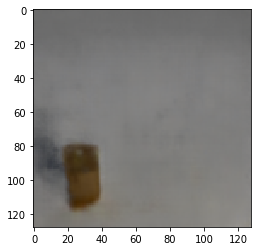

In [44]:
plt.figure()
plt.imshow(np.moveaxis(manip_recons[0, 1].detach().cpu().numpy(), [0, 1, 2], [2, 0, 1]) / 2. + 0.5)
plt.show()

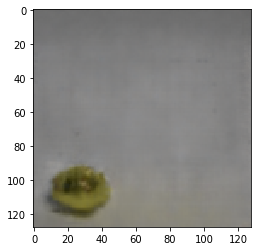

In [45]:
manip_slots = torch.clone(slots)
manip_slots[0, 1, :30] = 0.
manip_slots[0, 1]
manip_recon_combined, manip_recons, manip_masks, _ = net.module.forward_decoder(manip_slots)

plt.figure()
plt.imshow(np.moveaxis(manip_recons[0, 1].detach().cpu().numpy(), [0, 1, 2], [2, 0, 1]) / 2. + 0.5)
plt.show()